## Applied Data Science Capstone Project - Data Science Certification (IBM) by Mariana Ferreira ##
## Where to set up a café in Sitges, Spain?

## Table of contents

1. [Introduction: Business Problem](#introduction)
2. [Data](#data)
3. [Methodology](#methodology)
4. [Analysis](#analysis)
5. [Results and Discussion](#results)
6. [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project, we will attempt to determine the most optimal location for setting up a new café in the costal town of Sitges, Spain.

This project will use manually acquired district/neighborhood information of Sitges as well as the Foursquare API to find future competitors and other landmarks. 

Location is critical to the overall success of any business. 

In the case of cafés, there are many variables to consider to maximize the chances of prosperity. Some of these are: visibility, parking, demographics, 
points of interest in the area (schools, hospitals, public offices, etc)  and high foot traffic.

Sitges is a relatively small town, so the search will focus on finding **locations that are not extremely crowded by local cafés** and will favor **locations as close to the city center as possible**.

We will also focus on identifying the aforementioned **areas of interest**, since they usually signify more people going about by foot (foot traffic).

It is important to note that competition isn't necessarily a bad thing; a group of cafés can attract more people to the area over time, the key is to differentiate our business from the competition. 

## Data <a name="data"></a>

### Definition

Upon doing research, I discovered that, due to how small of a town Sitges is, there is no unified criteria regarding neighborhood/district division, which made it impossible to find a single source to scrape and create the database from. Therefore, using several resources (specifically, local real estate platforms like ("Idealista" https://www.idealista.com) I manually created a csv file including neighborhoods' names,  postcodes and coordinates, which I uploaded directly to my project. 


Based on the problem we just definied, factors that will influence our decission are:

* number of and distance to existing cafés in the neighborhood
* number of points of interest (universities, schools, public offices, etc)
* distance from neighborhood to city center



To find the number of existing cafés and landmarks and their location per neighborhood, we will be harnessing the power of the Foursquare API. 


### Download all necessary dependencies and packages

In [1]:
import pandas as pd
import os
import lxml
import numpy as np
from unicodedata import normalize
import json 

!pip3 install geopy 
from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize 

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!pip3 install folium==0.5.0
import folium 

!pip3 install geopy 
from geopy.geocoders import Nominatim 

print('Libraries imported.')

Libraries imported.


### Insert & clean Dataset

In [2]:
import types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_a0a2a5cb93344a4591c3d85f021565b4 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='9FcDBbw4ORn69Cq5J39T7beC9_5yxD9tdI-JKdOKwf_a',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_a0a2a5cb93344a4591c3d85f021565b4.get_object(Bucket='marianaferreiracapstoneproject2-donotdelete-pr-ydnsmoicujexow',Key='Sitges-Neighb.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

Sitges = pd.read_csv(body)

Sitges = Sitges.drop(['Unnamed: 4'], axis=1) #For some reason, when inserting the data, a new column is added, which I'm dropping as it's got no information.
Sitges = Sitges.dropna()

Sitges

,Neighborhood,Postal Code,Latitude,Longitude
0,Downtown Sitges,8870.0,41.2372,1.8059
1,Aiguadolç,8870.0,41.2348,1.8254
2,Urbanització Levantina,8870.0,41.2403,1.8249
3,Urbanització Montgavina,8870.0,41.2383,1.8313
4,Quint Mar,8870.0,41.2495,1.8661
5,Urbanització Vallpineda,8870.0,41.2459,1.7962
6,Poble Sec,8870.0,41.2439,1.8088
7,Els Molins,8870.0,41.2392,1.8170
8,La Plana,8870.0,41.2387,1.8097
9,Vinyet,8870.0,41.2344,1.7911


In [3]:
Sitges.dtypes

Neighborhood     object
Postal Code     float64
Latitude        float64
Longitude       float64
dtype: object

In [4]:
Sitges["Postal Code"]= Sitges["Postal Code"].astype(str) # We change the data type so we can replace the postal code value, which was changed due to formatting when inserting the data.
Sitges = Sitges.replace(to_replace ="8870.0", value ="08870") 
Sitges = Sitges.replace(to_replace ="Downtown Sitges", value ="Downtown Sitges/Sant Sebastià") 
Sitges

,Neighborhood,Postal Code,Latitude,Longitude
0,Downtown Sitges/Sant Sebastià,08870,41.2372,1.8059
1,Aiguadolç,08870,41.2348,1.8254
2,Urbanització Levantina,08870,41.2403,1.8249
3,Urbanització Montgavina,08870,41.2383,1.8313
4,Quint Mar,08870,41.2495,1.8661
5,Urbanització Vallpineda,08870,41.2459,1.7962
6,Poble Sec,08870,41.2439,1.8088
7,Els Molins,08870,41.2392,1.8170
8,La Plana,08870,41.2387,1.8097
9,Vinyet,08870,41.2344,1.7911


## Let's set up the coordinates for Sitges

In [5]:
address = 'Sitges, ES'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Sitges are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Sitges are 41.2366707, 1.8228136.


## Now we will visualize the map of Sitges with all its neighborhoods

In [43]:
map_Sitges = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for lat, lng, label in zip(Sitges['Latitude'], Sitges['Longitude'], Sitges['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='purple',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Sitges)  
    
map_Sitges

## Foursquare

In [7]:
CLIENT_ID = 'WWAF0PHCQNIOIPO3YQDSIGD3PUJJREQMTZNOTHA14BKVE2G2' # Foursquare ID
CLIENT_SECRET = 'LDXQRXGRA3CY2CXOIHYY2YBPIGKXP1JJI5IQ1URMOCCT3NOE' # Foursquare Secret
VERSION = '20210118' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WWAF0PHCQNIOIPO3YQDSIGD3PUJJREQMTZNOTHA14BKVE2G2
CLIENT_SECRET:LDXQRXGRA3CY2CXOIHYY2YBPIGKXP1JJI5IQ1URMOCCT3NOE


## Now, we will locate Downtown Sitges

In [8]:
Downtown_latitude = Sitges.loc[0, 'Latitude'] 
Downtown_longitude = Sitges.loc[0, 'Longitude'] 

neighb_name = 'Downtown Sitges'

print('Latitude and longitude values of {} are {}, {}.'.format(neighb_name, 
                                                               Downtown_latitude, 
                                                               Downtown_longitude))

Latitude and longitude values of Downtown Sitges are 41.2372, 1.8059.


## Let's get the top 100 cafes in Sitges within a radius of 3000 meters from Downtown

In [9]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 3000 # define radius


url = 'https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d16d941735,4bf58dd8d48988d128941735&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    Downtown_latitude, 
    Downtown_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d16d941735,4bf58dd8d48988d128941735&client_id=WWAF0PHCQNIOIPO3YQDSIGD3PUJJREQMTZNOTHA14BKVE2G2&client_secret=LDXQRXGRA3CY2CXOIHYY2YBPIGKXP1JJI5IQ1URMOCCT3NOE&v=20210118&ll=41.2372,1.8059&radius=3000&limit=100'

In [10]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '603bc9174fdbb60cde7ad38b'},
 'response': {'venues': [{'id': '4bed37eb6e8c20a1c2017061',
    'name': 'Mont Roig',
    'location': {'address': 'C. Marquès de Montroig, 11-13',
     'lat': 41.23602159203877,
     'lng': 1.8066037082311075,
     'labeledLatLngs': [{'label': 'display',
       'lat': 41.23602159203877,
       'lng': 1.8066037082311075}],
     'distance': 143,
     'postalCode': '08870',
     'cc': 'ES',
     'city': 'Sitges',
     'state': 'Cataluña',
     'country': 'España',
     'formattedAddress': ['C. Marquès de Montroig, 11-13',
      '08870 Sitges Cataluña',
      'España']},
    'categories': [{'id': '4bf58dd8d48988d16d941735',
      'name': 'Café',
      'pluralName': 'Cafés',
      'shortName': 'Café',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1614530839',
    'hasPerk': False},
   {'id': '4e66200a62e13e3bd03011d7',
    'n

In [11]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = pd.json_normalize(venues)
dataframe.head()

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet
0,4bed37eb6e8c20a1c2017061,Mont Roig,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1614530839,False,"C. Marquès de Montroig, 11-13",41.236022,1.806604,"[{'label': 'display', 'lat': 41.23602159203877...",143,08870,ES,Sitges,Cataluña,España,"[C. Marquès de Montroig, 11-13, 08870 Sitges C...",NaN
1,4e66200a62e13e3bd03011d7,Sitges Rock Cafe,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1614530839,False,NaN,41.237987,1.805919,"[{'label': 'display', 'lat': 41.23798680156633...",87,NaN,ES,Sitges,Cataluña,España,"[Sitges Cataluña, España]",NaN
2,51727d54e4b02cd2ba327959,Restaurante La Terraza de Rafa,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1614530839,False,NaN,41.236675,1.805088,"[{'label': 'display', 'lat': 41.23667526245117...",89,NaN,ES,NaN,NaN,España,[España],NaN
3,4bfd49e8e529c928f5abba8c,L'Aixeta,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1614530839,False,NaN,41.238102,1.807510,"[{'label': 'display', 'lat': 41.23810225594527...",168,NaN,ES,NaN,NaN,España,[España],NaN
4,5b931f6bbcbf7a002ceca396,Entre Pans Cafeteria,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1614530839,False,NaN,41.236210,1.807849,"[{'label': 'display', 'lat': 41.23621, 'lng': ...",196,08870,ES,Sitges,Cataluña,España,"[08870 Sitges Cataluña, España]",NaN


## Now, let's clean the data

In [12]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
Cafes_Sitges = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
Cafes_Sitges['categories'] = Cafes_Sitges.apply(get_category_type, axis=1)

# clean column names by keeping only last term
Cafes_Sitges.columns = [column.split('.')[-1] for column in Cafes_Sitges.columns]

Cafes_Sitges

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id
0,Mont Roig,Café,"C. Marquès de Montroig, 11-13",41.236022,1.806604,"[{'label': 'display', 'lat': 41.23602159203877...",143,08870,ES,Sitges,Cataluña,España,"[C. Marquès de Montroig, 11-13, 08870 Sitges C...",NaN,4bed37eb6e8c20a1c2017061
1,Sitges Rock Cafe,Café,NaN,41.237987,1.805919,"[{'label': 'display', 'lat': 41.23798680156633...",87,NaN,ES,Sitges,Cataluña,España,"[Sitges Cataluña, España]",NaN,4e66200a62e13e3bd03011d7
2,Restaurante La Terraza de Rafa,Café,NaN,41.236675,1.805088,"[{'label': 'display', 'lat': 41.23667526245117...",89,NaN,ES,NaN,NaN,España,[España],NaN,51727d54e4b02cd2ba327959
3,L'Aixeta,Café,NaN,41.238102,1.807510,"[{'label': 'display', 'lat': 41.23810225594527...",168,NaN,ES,NaN,NaN,España,[España],NaN,4bfd49e8e529c928f5abba8c
4,Entre Pans Cafeteria,Café,NaN,41.236210,1.807849,"[{'label': 'display', 'lat': 41.23621, 'lng': ...",196,08870,ES,Sitges,Cataluña,España,"[08870 Sitges Cataluña, España]",NaN,5b931f6bbcbf7a002ceca396
5,Bar Pony,Cafeteria,NaN,41.237908,1.806404,"[{'label': 'display', 'lat': 41.237908, 'lng':...",89,NaN,ES,NaN,NaN,España,[España],NaN,53836f54498e15919e982ae4
6,Granier,Café,"C/ Parellades, 28",41.236362,1.808394,"[{'label': 'display', 'lat': 41.23636235960679...",228,08870,ES,Sitges,Cataluña,España,"[C/ Parellades, 28, 08870 Sitges Cataluña, Esp...",NaN,4f58fbbfe4b027eb92790319
7,Genesis,Café,Carrer de la Sinia Morera,41.238344,1.805486,"[{'label': 'display', 'lat': 41.23834387, 'lng...",131,08870,ES,Sitges,Cataluña,España,"[Carrer de la Sinia Morera, 08870 Sitges Catal...",NaN,4d496a925129a35d4b6f39ac
8,cin5,Café,NaN,41.236401,1.809169,"[{'label': 'display', 'lat': 41.236401, 'lng':...",287,08870,ES,Sitges,Cataluña,España,"[08870 Sitges Cataluña, España]",NaN,5e0628f0a5f58500073d4d68
9,Cafè del Món,Café,"C. Illa de Cuba, 43",41.238548,1.808941,"[{'label': 'display', 'lat': 41.23854824178962...",295,08870,ES,Sitges,Cataluña,España,"[C. Illa de Cuba, 43 (Artur Carbonell), 08870 ...",Artur Carbonell,4dc6e9dc45dd264552959480


In [13]:
Cafes_Sitges['postalCode'] = Cafes_Sitges['postalCode'].fillna('08870')
Cafes_Sitges['city'] = Cafes_Sitges['city'].fillna('Sitges')
Cafes_Sitges['state'] = Cafes_Sitges['state'].fillna('Cataluña')
Cafes_Sitges['crossStreet'] = Cafes_Sitges['crossStreet'].fillna(0)
Cafes_Sitges['address'] = Cafes_Sitges['address'].fillna(0)
Cafes_Sitges = Cafes_Sitges.drop(['labeledLatLngs','crossStreet'], axis=1)

Cafes_Sitges = Cafes_Sitges.drop(labels=[24,27,42], axis=0)


Cafes_Sitges


,name,categories,address,lat,lng,distance,postalCode,cc,city,state,country,formattedAddress,id
0,Mont Roig,Café,"C. Marquès de Montroig, 11-13",41.236022,1.806604,143,08870,ES,Sitges,Cataluña,España,"[C. Marquès de Montroig, 11-13, 08870 Sitges C...",4bed37eb6e8c20a1c2017061
1,Sitges Rock Cafe,Café,0,41.237987,1.805919,87,08870,ES,Sitges,Cataluña,España,"[Sitges Cataluña, España]",4e66200a62e13e3bd03011d7
2,Restaurante La Terraza de Rafa,Café,0,41.236675,1.805088,89,08870,ES,Sitges,Cataluña,España,[España],51727d54e4b02cd2ba327959
3,L'Aixeta,Café,0,41.238102,1.807510,168,08870,ES,Sitges,Cataluña,España,[España],4bfd49e8e529c928f5abba8c
4,Entre Pans Cafeteria,Café,0,41.236210,1.807849,196,08870,ES,Sitges,Cataluña,España,"[08870 Sitges Cataluña, España]",5b931f6bbcbf7a002ceca396
5,Bar Pony,Cafeteria,0,41.237908,1.806404,89,08870,ES,Sitges,Cataluña,España,[España],53836f54498e15919e982ae4
6,Granier,Café,"C/ Parellades, 28",41.236362,1.808394,228,08870,ES,Sitges,Cataluña,España,"[C/ Parellades, 28, 08870 Sitges Cataluña, Esp...",4f58fbbfe4b027eb92790319
7,Genesis,Café,Carrer de la Sinia Morera,41.238344,1.805486,131,08870,ES,Sitges,Cataluña,España,"[Carrer de la Sinia Morera, 08870 Sitges Catal...",4d496a925129a35d4b6f39ac
8,cin5,Café,0,41.236401,1.809169,287,08870,ES,Sitges,Cataluña,España,"[08870 Sitges Cataluña, España]",5e0628f0a5f58500073d4d68
9,Cafè del Món,Café,"C. Illa de Cuba, 43",41.238548,1.808941,295,08870,ES,Sitges,Cataluña,España,"[C. Illa de Cuba, 43 (Artur Carbonell), 08870 ...",4dc6e9dc45dd264552959480


## Let's visualize the cafés

In [14]:
Cafes_Sitges.name

0                          Mont Roig
1                   Sitges Rock Cafe
2     Restaurante La Terraza de Rafa
3                           L'Aixeta
4               Entre Pans Cafeteria
5                           Bar Pony
6                            Granier
7                            Genesis
8                               cin5
9                       Cafè del Món
10                  Central Bar Cafe
11                      Cafe Bar Roy
12                        Cafe Saula
13                   Bar Port Alegre
14                        Casa Tecla
15                 Cafeteria Estacio
16                             Sirka
17                         Jijonenca
18                       Café Berlin
19                        Bar La Era
20              Pastelería La Bóvila
21                Pastisseria Sabaté
22               Starbucks On The Go
23                       Bar del Mar
25                Bar Brindis Dino's
26                               Kfe
28        Bar Slurp Port d'Aiguadolc
2

In [15]:
Cafes_Sitges=Cafes_Sitges.set_index(['id'])

In [45]:
map_Sitges_cafes = folium.Map(location=[latitude, longitude], zoom_start=15) 

#Add red marker where "Downtown Sitges" is
folium.features.CircleMarker(
     [latitude, longitude],
     radius=10,
     color='red',
     popup='Downtown Sitges',
     fill = True,
     fill_color = 'purple',
     fill_opacity = 0.6
 ).add_to(map_Sitges_cafes)


for lat, lng, label in zip(Cafes_Sitges.lat, Cafes_Sitges.lng, Cafes_Sitges.categories):
     folium.features.CircleMarker(
         [lat, lng],
         radius=5,
         color='blue',
         popup=label,
         fill = True,
         fill_color='blue',
         fill_opacity=0.6
     ).add_to(map_Sitges_cafes)

# display map
map_Sitges_cafes

## Now let's locate points of interest within the same radius

In [17]:
LIMIT = 150 # limit of number of venues returned by Foursquare API
radius = 3000 # define radius


# Category IDs corresponding to Plazas, Hospitals, Schools and Post Offices, were taken from Foursquare web site (https://developer.foursquare.com/docs/resources/categories):

url2 = 'https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d13b941735,4bf58dd8d48988d196941735,4bf58dd8d48988d172941735,4bf58dd8d48988d164941735,52e81612bcbc57f1066b7a25&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    Downtown_latitude, 
    Downtown_longitude, 
    radius, 
    LIMIT)
url2 # display URL


'https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d13b941735,4bf58dd8d48988d196941735,4bf58dd8d48988d172941735,4bf58dd8d48988d164941735,52e81612bcbc57f1066b7a25&client_id=WWAF0PHCQNIOIPO3YQDSIGD3PUJJREQMTZNOTHA14BKVE2G2&client_secret=LDXQRXGRA3CY2CXOIHYY2YBPIGKXP1JJI5IQ1URMOCCT3NOE&v=20210118&ll=41.2372,1.8059&radius=3000&limit=150'

In [18]:
results1 = requests.get(url2).json()
results1

{'meta': {'code': 200, 'requestId': '603bc91891a9d65b66e9b768'},
 'response': {'venues': [{'id': '4e13528e22713f7d7be1be6b',
    'name': 'Plaça Espanya',
    'location': {'address': 'Plaça Espanya',
     'lat': 41.236430864292444,
     'lng': 1.8057081663286727,
     'labeledLatLngs': [{'label': 'display',
       'lat': 41.236430864292444,
       'lng': 1.8057081663286727}],
     'distance': 87,
     'cc': 'ES',
     'city': 'Sitges',
     'state': 'Cataluña',
     'country': 'España',
     'formattedAddress': ['Plaça Espanya', 'Sitges Cataluña', 'España']},
    'categories': [{'id': '4bf58dd8d48988d164941735',
      'name': 'Plaza',
      'pluralName': 'Plazas',
      'shortName': 'Plaza',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/plaza_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1614530841',
    'hasPerk': False},
   {'id': '4e5bf606183883e00c02ea54',
    'name': 'Plaça de la Indústria',
    'location': {'address': 

In [19]:
venues1 = results1['response']['venues']
    
poi = pd.json_normalize(venues1) 

poi

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,location.postalCode,venuePage.id
0,4e13528e22713f7d7be1be6b,Plaça Espanya,"[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",v-1614530841,False,Plaça Espanya,41.236431,1.805708,"[{'label': 'display', 'lat': 41.23643086429244...",87,ES,Sitges,Cataluña,España,"[Plaça Espanya, Sitges Cataluña, España]",NaN,NaN,NaN
1,4e5bf606183883e00c02ea54,Plaça de la Indústria,"[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",v-1614530841,False,Plaça de la Indústria,41.235530,1.806909,"[{'label': 'display', 'lat': 41.23553006551115...",204,ES,Sitges,Cataluña,España,[Plaça de la Indústria (Carrer de Joan Tarrida...,Carrer de Joan Tarrida,08870,NaN
2,4ea6b41449015fc80b4f10e8,Oficina Correos,"[{'id': '4bf58dd8d48988d172941735', 'name': 'P...",v-1614530841,False,Pl.Mossen Joan Llopis Pi 1,41.236391,1.805487,"[{'label': 'display', 'lat': 41.23639104702385...",96,ES,Sitges,Cataluña,España,"[Pl.Mossen Joan Llopis Pi 1, 8870 Sitges Catal...",NaN,8870,NaN
3,5b9427efb77c77002c205e7b,Judgement Square,"[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",v-1614530841,False,NaN,41.235579,1.806881,"[{'label': 'display', 'lat': 41.235579, 'lng':...",198,ES,Sitges,Cataluña,España,"[08870 Sitges Cataluña, España]",NaN,08870,NaN
4,4c32574a213c2d7fe74f355d,Cap de la Vila - Sitges,"[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",v-1614530841,False,Plaça Cap de la Vila,41.236622,1.809504,"[{'label': 'display', 'lat': 41.23662192674049...",308,ES,Sitges,Cataluña,España,"[Plaça Cap de la Vila, 08870 Sitges Cataluña, ...",NaN,08870,NaN
5,4edd12c26c2547bc65d6c423,"Sitges, Plaça Catalunya","[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",v-1614530841,False,NaN,41.240349,1.812016,"[{'label': 'display', 'lat': 41.24034925276123...",620,ES,NaN,NaN,España,[España],NaN,NaN,NaN
6,4c9cbc157c096dcbd926c4d1,Mirador La Levantina,"[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",v-1614530841,False,NaN,41.243113,1.829838,"[{'label': 'display', 'lat': 41.24311302570977...",2109,ES,NaN,NaN,España,[España],NaN,NaN,NaN
7,5a4cb5fa60255e28c539614d,Plaza Diego Casanova Muñoz,"[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",v-1614530841,False,NaN,41.245963,1.793883,"[{'label': 'display', 'lat': 41.245963, 'lng':...",1401,ES,San Pedro de Ribas,Cataluña,España,"[08810 San Pedro de Ribas Cataluña, España]",NaN,08810,NaN
8,570d0796498ed395d1222f8c,Racó de la Fragata,"[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",v-1614530841,False,NaN,41.234501,1.811040,"[{'label': 'display', 'lat': 41.234501, 'lng':...",524,ES,Sitges,Cataluña,España,"[08870 Sitges Cataluña, España]",NaN,08870,NaN
9,4c742c73c219224b671a9f28,Plaça del Baluard,"[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",v-1614530841,False,NaN,41.234828,1.810726,"[{'label': 'display', 'lat': 41.23482790312098...",482,ES,NaN,NaN,España,[España],NaN,NaN,NaN


## Let's clean the data

In [20]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
poi_sitges = poi.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
poi_sitges['categories'] = poi_sitges.apply(get_category_type, axis=1)

# clean column names by keeping only last term
poi_sitges.columns = [column.split('.')[-1] for column in poi_sitges.columns]

poi_sitges

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id
0,Plaça Espanya,Plaza,Plaça Espanya,41.236431,1.805708,"[{'label': 'display', 'lat': 41.23643086429244...",87,NaN,ES,Sitges,Cataluña,España,"[Plaça Espanya, Sitges Cataluña, España]",NaN,4e13528e22713f7d7be1be6b
1,Plaça de la Indústria,Plaza,Plaça de la Indústria,41.235530,1.806909,"[{'label': 'display', 'lat': 41.23553006551115...",204,08870,ES,Sitges,Cataluña,España,[Plaça de la Indústria (Carrer de Joan Tarrida...,Carrer de Joan Tarrida,4e5bf606183883e00c02ea54
2,Oficina Correos,Post Office,Pl.Mossen Joan Llopis Pi 1,41.236391,1.805487,"[{'label': 'display', 'lat': 41.23639104702385...",96,8870,ES,Sitges,Cataluña,España,"[Pl.Mossen Joan Llopis Pi 1, 8870 Sitges Catal...",NaN,4ea6b41449015fc80b4f10e8
3,Judgement Square,Plaza,NaN,41.235579,1.806881,"[{'label': 'display', 'lat': 41.235579, 'lng':...",198,08870,ES,Sitges,Cataluña,España,"[08870 Sitges Cataluña, España]",NaN,5b9427efb77c77002c205e7b
4,Cap de la Vila - Sitges,Plaza,Plaça Cap de la Vila,41.236622,1.809504,"[{'label': 'display', 'lat': 41.23662192674049...",308,08870,ES,Sitges,Cataluña,España,"[Plaça Cap de la Vila, 08870 Sitges Cataluña, ...",NaN,4c32574a213c2d7fe74f355d
5,"Sitges, Plaça Catalunya",Plaza,NaN,41.240349,1.812016,"[{'label': 'display', 'lat': 41.24034925276123...",620,NaN,ES,NaN,NaN,España,[España],NaN,4edd12c26c2547bc65d6c423
6,Mirador La Levantina,Plaza,NaN,41.243113,1.829838,"[{'label': 'display', 'lat': 41.24311302570977...",2109,NaN,ES,NaN,NaN,España,[España],NaN,4c9cbc157c096dcbd926c4d1
7,Plaza Diego Casanova Muñoz,Plaza,NaN,41.245963,1.793883,"[{'label': 'display', 'lat': 41.245963, 'lng':...",1401,08810,ES,San Pedro de Ribas,Cataluña,España,"[08810 San Pedro de Ribas Cataluña, España]",NaN,5a4cb5fa60255e28c539614d
8,Racó de la Fragata,Plaza,NaN,41.234501,1.811040,"[{'label': 'display', 'lat': 41.234501, 'lng':...",524,08870,ES,Sitges,Cataluña,España,"[08870 Sitges Cataluña, España]",NaN,570d0796498ed395d1222f8c
9,Plaça del Baluard,Plaza,NaN,41.234828,1.810726,"[{'label': 'display', 'lat': 41.23482790312098...",482,NaN,ES,NaN,NaN,España,[España],NaN,4c742c73c219224b671a9f28


In [21]:
poi_sitges['postalCode'] = poi_sitges['postalCode'].fillna('08870')
poi_sitges['city'] = poi_sitges['city'].fillna('Sitges')
poi_sitges['state'] = poi_sitges['state'].fillna('Cataluña')
poi_sitges['address'] = poi_sitges['address'].fillna(0)
poi_sitges = poi_sitges.drop(['labeledLatLngs','crossStreet'], axis=1)


poi_sitges

,name,categories,address,lat,lng,distance,postalCode,cc,city,state,country,formattedAddress,id
0,Plaça Espanya,Plaza,Plaça Espanya,41.236431,1.805708,87,08870,ES,Sitges,Cataluña,España,"[Plaça Espanya, Sitges Cataluña, España]",4e13528e22713f7d7be1be6b
1,Plaça de la Indústria,Plaza,Plaça de la Indústria,41.235530,1.806909,204,08870,ES,Sitges,Cataluña,España,[Plaça de la Indústria (Carrer de Joan Tarrida...,4e5bf606183883e00c02ea54
2,Oficina Correos,Post Office,Pl.Mossen Joan Llopis Pi 1,41.236391,1.805487,96,8870,ES,Sitges,Cataluña,España,"[Pl.Mossen Joan Llopis Pi 1, 8870 Sitges Catal...",4ea6b41449015fc80b4f10e8
3,Judgement Square,Plaza,0,41.235579,1.806881,198,08870,ES,Sitges,Cataluña,España,"[08870 Sitges Cataluña, España]",5b9427efb77c77002c205e7b
4,Cap de la Vila - Sitges,Plaza,Plaça Cap de la Vila,41.236622,1.809504,308,08870,ES,Sitges,Cataluña,España,"[Plaça Cap de la Vila, 08870 Sitges Cataluña, ...",4c32574a213c2d7fe74f355d
5,"Sitges, Plaça Catalunya",Plaza,0,41.240349,1.812016,620,08870,ES,Sitges,Cataluña,España,[España],4edd12c26c2547bc65d6c423
6,Mirador La Levantina,Plaza,0,41.243113,1.829838,2109,08870,ES,Sitges,Cataluña,España,[España],4c9cbc157c096dcbd926c4d1
7,Plaza Diego Casanova Muñoz,Plaza,0,41.245963,1.793883,1401,08810,ES,San Pedro de Ribas,Cataluña,España,"[08810 San Pedro de Ribas Cataluña, España]",5a4cb5fa60255e28c539614d
8,Racó de la Fragata,Plaza,0,41.234501,1.811040,524,08870,ES,Sitges,Cataluña,España,"[08870 Sitges Cataluña, España]",570d0796498ed395d1222f8c
9,Plaça del Baluard,Plaza,0,41.234828,1.810726,482,08870,ES,Sitges,Cataluña,España,[España],4c742c73c219224b671a9f28


## Let's visualize both the points of interest and the cafés

In [46]:
map_Sitges_cafes_poi = folium.Map(location=[latitude, longitude], zoom_start=14) 

#Add red marker where "Downtown Sitges" is
folium.features.CircleMarker(
     [latitude, longitude],
     radius=10,
     color='red',
     popup='Downtown Sitges',
     fill = True,
     fill_color = 'red',
     fill_opacity = 0.6
 ).add_to(map_Sitges_cafes_poi)


for lat, lng, label in zip(Cafes_Sitges.lat, Cafes_Sitges.lng, Cafes_Sitges.categories):
     folium.features.CircleMarker(
         [lat, lng],
         radius=5,
         color='blue',
         popup=label,
         fill = True,
         fill_color='blue',
         fill_opacity=0.6
     ).add_to(map_Sitges_cafes_poi)
        

for lat, lng, label in zip(poi_sitges.lat, poi_sitges.lng, poi_sitges.categories):
     folium.features.CircleMarker(
         [lat, lng],
         radius=5,
         color='green',
         popup=label,
         fill = True,
         fill_color='green',
         fill_opacity=0.6
     ).add_to(map_Sitges_cafes_poi)
        

map_Sitges_cafes_poi


#### This map shows what our previous research suggested; areas where there are hospitals, schools, post offices and/or parks, tend to be preffered when it comes to setting up a café.

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting specifiy locations around areas where there are points of interest, particularly those with low number of cafés nearby. 

In these first steps we have collected the required data: neighborhoods' definition and location of cafés and points of interest per neighborhood. 

The next step in our analysis will be determining 'venue frequency' across different areas of Sitges and focus our attention on areas where there are at least two points of interest and less than four cafés (competition).
 
In the third and final step, we will focus on most promising areas (based on the previously discussed criteria) and within those, mark on the map, specific locations where we could set up our business. 

## Analysis <a name="analysis"></a>

### Let's merge our dataframes to create one comprehensive dataset featuring all venues; cafés and points of interest.

In [23]:
venues_merged = Cafes_Sitges.append(poi_sitges)
venues_merged = venues_merged.reset_index(drop=True)
venues_merged = venues_merged.drop(['id','formattedAddress','distance'], axis=1)

pd.set_option('display.max_rows', venues_merged.shape[0]+1)

venues_merged.style 


,name,categories,address,lat,lng,postalCode,cc,city,state,country
0,Mont Roig,Café,"C. Marquès de Montroig, 11-13",41.236022,1.806604,08870,ES,Sitges,Cataluña,España
1,Sitges Rock Cafe,Café,0,41.237987,1.805919,08870,ES,Sitges,Cataluña,España
2,Restaurante La Terraza de Rafa,Café,0,41.236675,1.805088,08870,ES,Sitges,Cataluña,España
3,L'Aixeta,Café,0,41.238102,1.807510,08870,ES,Sitges,Cataluña,España
4,Entre Pans Cafeteria,Café,0,41.236210,1.807849,08870,ES,Sitges,Cataluña,España
5,Bar Pony,Cafeteria,0,41.237908,1.806404,08870,ES,Sitges,Cataluña,España
6,Granier,Café,"C/ Parellades, 28",41.236362,1.808394,08870,ES,Sitges,Cataluña,España
7,Genesis,Café,Carrer de la Sinia Morera,41.238344,1.805486,08870,ES,Sitges,Cataluña,España
8,cin5,Café,0,41.236401,1.809169,08870,ES,Sitges,Cataluña,España
9,Cafè del Món,Café,"C. Illa de Cuba, 43",41.238548,1.808941,08870,ES,Sitges,Cataluña,España


## Now, let's clean this dataframe a bit further for simplicity

In [24]:
Cafes_Sitges["Neighborhood"] = ['Downtown Sitges/Sant Sebastià', 'Downtown Sitges/Sant Sebastià', 'Downtown Sitges/Sant Sebastià','Downtown Sitges/Sant Sebastià','Downtown Sitges/Sant Sebastià','Downtown Sitges/Sant Sebastià','Downtown Sitges/Sant Sebastià','Downtown Sitges/Sant Sebastià','Downtown Sitges/Sant Sebastià','La Plana',
              'Downtown Sitges/Sant Sebastià','Downtown Sitges/Sant Sebastià','La Plana','Downtown Sitges/Sant Sebastià', 'La Plana','Downtown Sitges/Sant Sebastià','La Plana','Downtown Sitges/Sant Sebastià','Downtown Sitges/Sant Sebastià','La Plana',
              'Poble Sec','Downtown Sitges/Sant Sebastià','Urbanització Levantina','Els Molins','La Plana', 'Downtown Sitges/Sant Sebastià','Downtown Sitges/Sant Sebastià', 'Aiguadolç','Vinyet','Downtown Sitges/Sant Sebastià',
              'Downtown Sitges/Sant Sebastià','La Plana','Els Molins','Downtown Sitges/Sant Sebastià','La Plana','Downtown Sitges/Sant Sebastià','Downtown Sitges/Sant Sebastià','Poble Sec','Vinyet','Downtown Sitges/Sant Sebastià',
              'Downtown Sitges/Sant Sebastià']


Cafes_Sitges['categories'] = Cafes_Sitges['categories'].replace(['Cafeteria'],'Café')
Cafes_Sitges['categories'] = Cafes_Sitges['categories'].replace(['Cocktail Bar'],'Café')
Cafes_Sitges['categories'] = Cafes_Sitges['categories'].replace(['Tapas Restaurant'],'Café')
Cafes_Sitges['categories'] = Cafes_Sitges['categories'].replace(['Coffee Shop'],'Café')
                                
                                
poi_sitges["Neighborhood"]=['Downtown Sitges/Sant Sebastià','Downtown Sitges/Sant Sebastià','Downtown Sitges/Sant Sebastià','Downtown Sitges/Sant Sebastià','Poble Sec','Downtown Sitges/Sant Sebastià','Urbanització Levantina','Urbanització Vallpineda','Downtown Sitges/Sant Sebastià',
              'Downtown Sitges/Sant Sebastià','Downtown Sitges/Sant Sebastià','Downtown Sitges/Sant Sebastià', 'Urbanització Vallpineda','Els Molins','Downtown Sitges/Sant Sebastià','Aiguadolç','Downtown Sitges/Sant Sebastià','Els Molins','La Plana',
              'Poble Sec','Downtown Sitges/Sant Sebastià','La Plana','Poble Sec','Urbanització Vallpineda','La Plana','Els Molins']

poi_sitges['categories'] = poi_sitges['categories'].replace(['Nursery School'],'School')
poi_sitges['categories'] = poi_sitges['categories'].replace(['Elementary School'],'School')
poi_sitges['categories'] = poi_sitges['categories'].replace(['Student Center'],'School')
poi_sitges['categories'] = poi_sitges['categories'].replace(['College Classroom'],'School')


In [25]:
import sys
sys.setrecursionlimit(10**6) 

## Now, let's measure the frequency of cafes per neighborhood

In [26]:
Cafes_by_neighb = Cafes_Sitges[['categories', 'Neighborhood']].copy()
count = Cafes_by_neighb.groupby(['Neighborhood']).count() 
count

,categories
Neighborhood,
Aiguadolç,1
Downtown Sitges/Sant Sebastià,25
Els Molins,2
La Plana,8
Poble Sec,2
Urbanització Levantina,1
Vinyet,2


Text(0.5, 1.0, 'Amount of cafés per neighborhood')

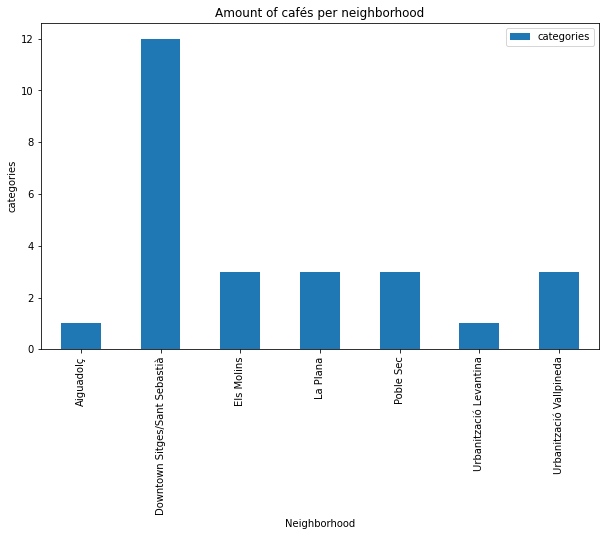

In [47]:
count.plot(kind='bar', figsize=(10, 6), rot=90) 

plt.xlabel('Neighborhood')
plt.ylabel('categories')
plt.title('Amount of cafés per neighborhood')

## Now, let's measure the frequency of points of interest per neighborhood

In [28]:
poi_by_neighb = poi_sitges[['categories', 'Neighborhood']].copy()
count = poi_by_neighb.groupby(['Neighborhood']).count() 
count

,categories
Neighborhood,
Aiguadolç,1
Downtown Sitges/Sant Sebastià,12
Els Molins,3
La Plana,3
Poble Sec,3
Urbanització Levantina,1
Urbanització Vallpineda,3


Text(0.5, 1.0, 'Amount of points of interest per neighborhood')

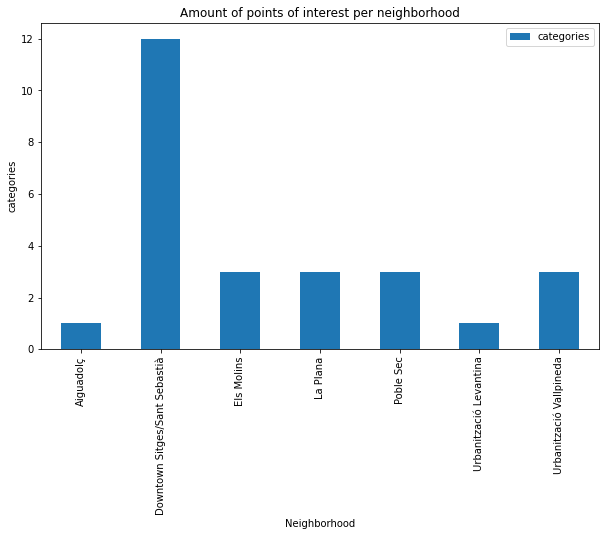

In [29]:
count.plot(kind='bar', figsize=(10, 6), rot=90) 

plt.xlabel('Neighborhood')
plt.ylabel('categories')
plt.title('Amount of points of interest per neighborhood')

## Also, let's visualize all venues and neighborhoods

In [42]:
map_venues_neighb = folium.Map(location=[latitude, longitude], zoom_start=14) 


for lat, lng, label in zip(Cafes_Sitges.lat, Cafes_Sitges.lng, Cafes_Sitges.categories):
     folium.features.CircleMarker(
         [lat, lng],
         radius=5,
         color='blue',
         popup=label,
         fill = True,
         fill_color='blue',
         fill_opacity=0.6
     ).add_to(map_venues_neighb)
        

for lat, lng, label in zip(poi_sitges.lat, poi_sitges.lng, poi_sitges.categories):
     folium.features.CircleMarker(
         [lat, lng],
         radius=5,
         color='green',
         popup=label,
         fill = True,
         fill_color='green',
         fill_opacity=0.6
     ).add_to(map_venues_neighb)
        
for lat, lng, label in zip(Sitges.Latitude, Sitges.Longitude, Sitges.Neighborhood):
     folium.features.CircleMarker(
         [lat, lng],
         radius=15,
         color='red',
         popup=label,
         fill = True,
         fill_color='red',
         fill_opacity=0.6
     ).add_to(map_venues_neighb)
        

map_venues_neighb

### Now that we have a better sense of where most of the venues are located, we'll proceed to mark on the map specific places where we could set up our café. 

#### We analyzed the map above and created a dataframe with potential locations and their coordinates, which we will import directly to the project. 

In [33]:

body = client_a0a2a5cb93344a4591c3d85f021565b4.get_object(Bucket='marianaferreiracapstoneproject2-donotdelete-pr-ydnsmoicujexow',Key='Potential-Location.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

Potential_Locations1 = pd.read_csv(body)
Potential_Locations1


,PL,Latitude,Longitude
0,Location 1,41.235474,1.811303
1,Location 2,41.234948,1.811558
2,Location 3,41.234994,1.809444
3,Location 4,41.235530,1.806950
4,Location 5,41.238215,1.808291
5,Location 6,41.238697,1.809786
6,Location 7,41.240330,1.809360
7,Location 8,41.236170,1.805771
8,Location 9,41.238836,1.817763


In [41]:
map_venues_final = folium.Map(location=[latitude, longitude], zoom_start=14.5) 


for lat, lng, label in zip(Cafes_Sitges.lat, Cafes_Sitges.lng, Cafes_Sitges.categories):
     folium.features.CircleMarker(
         [lat, lng],
         radius=5,
         color='blue',
         popup=label,
         fill = True,
         fill_color='blue',
         fill_opacity=0.6
     ).add_to(map_venues_final)
        

for lat, lng, label in zip(poi_sitges.lat, poi_sitges.lng, poi_sitges.categories):
     folium.features.CircleMarker(
         [lat, lng],
         radius=5,
         color='green',
         popup=label,
         fill = True,
         fill_color='green',
         fill_opacity=0.6
     ).add_to(map_venues_final)
        
        
for lat, lng, label in zip(Potential_Locations1.Latitude, Potential_Locations1.Longitude, Potential_Locations1.PL):
     folium.features.CircleMarker(
         [lat, lng],
         radius=15,
         color='yellow',
         popup=label,
         fill = True,
         fill_color='yellow',
         fill_opacity=0.6
     ).add_to(map_venues_final)
        

map_venues_final

### As seen in our map, points marked in yellow represent potential locations for setting up our new business successfully. 

## Results and Discussion <a name="results"></a>

Sitges is a small town in Spain, which posed a challenge in terms of finding information regarding the neighborhoods and areas where it was not already crowded by many other cafés. 

We manually created a database featuring all neighborhoods by analysing local real state and tourism information. 

We then used the Foursquare API to find all cafés in town, as well as points of interest where there is potentially high foot traffic, which is one of the factors which contributes to a successful cafés. 

We then created a map as well as bar charts with all the aforementioned venues, to determine the neighborhoods with the highest venue density.

After that, we discovered that most venues are concentrated around Downtown and La Plana. Other neighborhoods are mostly residential areas, which feature less points of interest and less foot traffic and are therefore, less likely to be the best options for setting up a new, successful business.

Our analysis shows that despite the limitations, there are still areas near points of interest (with foot traffic), where we could  set up a new café. The result of this analysis is nine potential candidates. 

These areas are, mostly around Downtown and La Plana, near at least two points of interest and around less than four competitors. 

## Conclusion <a name="conclusion"></a>

The purpose of this project was to identify Sitges' areas close to the center, with a low number of cafés and potentially high foot traffic, in order to aid future business owners in narrowing down the search for optimal location for a new café. 

By using Foursquare data we have determined venue density distribution across town. 

After creating maps and charts, we have identified the neighborhoods with the most potential. 

We have then created a database of locations which satisfy our requirements, to be used as starting points for final exploration. 

Final decission on optimal café location will be made by future business owners based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration proximity to major roads, real estate availability, prices, distinctive characteristics of the competions and the new business, among others.